In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# model restore
sess=tf.Session()
saver = tf.train.import_meta_graph('model.ckpt-100.meta')
saver.restore(sess, tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./model.ckpt-100


In [ ]:
# get the default graph
graph = tf.get_default_graph()

In [ ]:
# train test set load
vols = sio.loadmat('./sensorimotor_4D_sample.mat')
X_train, X_test, y_train, y_test = vols['X_train'], vols['X_test'], vols['y_train'], vols['y_test']

x_mean = np.mean(X_train)
x_std = np.std(X_train)
X_tr_centered = (X_train - x_mean)/x_std
X_ts_centered = (X_test - x_mean)/x_std
# 0:AD 1:RH 2:LH 3:VIS
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
# sorting
srt_idx = np.argsort(y_test)
X_ts_centered = X_ts_centered[srt_idx]
y_test = y_test[srt_idx]

In [ ]:
del X_tr_centered, y_train

In [ ]:
# placeholder load
tf_x = graph.get_tensor_by_name("tf_x:0") # shape:(none,53,63,46)
is_train = graph.get_tensor_by_name("is_train:0")

In [ ]:
# get the 3rd conv layer tensor
output_tensor = graph.get_tensor_by_name('conv3d_2/Relu:0')

In [ ]:
# loop
rslt = np.zeros((120,53,63,46))
for vi in range(116,120):
    start_time = time.time()
    input_image = X_ts_centered[vi,:]
    x_value = np.expand_dims(input_image, axis=0)
    conv3_fms = sess.run(output_tensor,{tf_x:x_value,is_train:False})
    conv3_fm_avg = np.mean(conv3_fms.squeeze(),axis=3)
    thr = np.percentile(conv3_fm_avg,99)
    idx = np.where(conv3_fm_avg > thr)
    print(vi,idx)
    nnn = idx[0].shape[0]
    tmpnn = np.zeros((nnn,53,63,46))
    for nn in range(nnn):
        tp = np.zeros((32,53,63,46))
        for ci in range(32):
            out_center = output_tensor[:,idx[0][nn],idx[1][nn],idx[2][nn],ci]
            # define the calculation
            cal = tf.gradients(out_center,tf_x)[0]
            x_value = np.expand_dims(input_image, axis=0)
            # get the gradients
            gradients = sess.run(cal, {tf_x:x_value,is_train:False})
            tp[ci] = gradients
        tmpnn[nn] = np.mean(tp, axis=0)
    rslt[vi] = np.mean(tmpnn, axis=0)
    print(time.time() - start_time, 'seconds')

Task # : 0


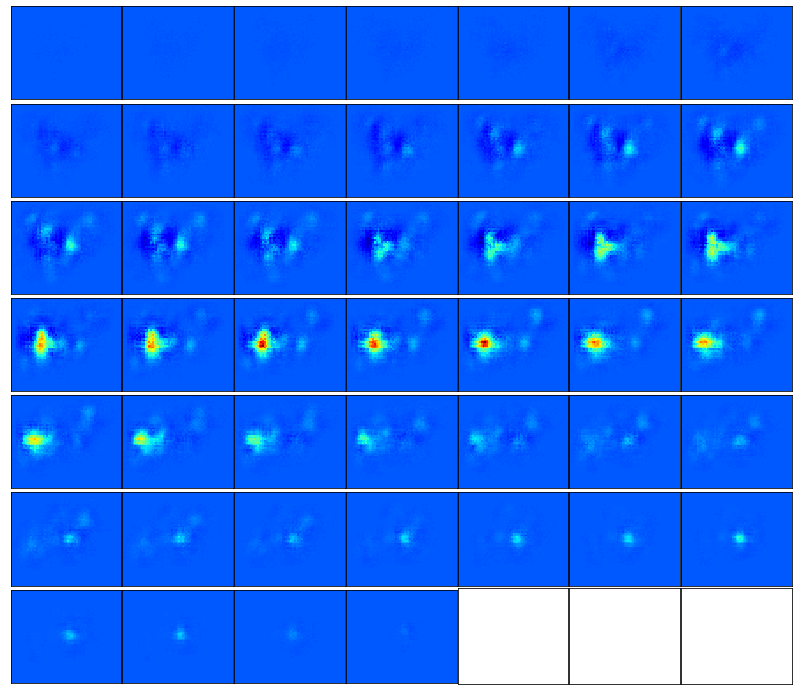

Task # : 1


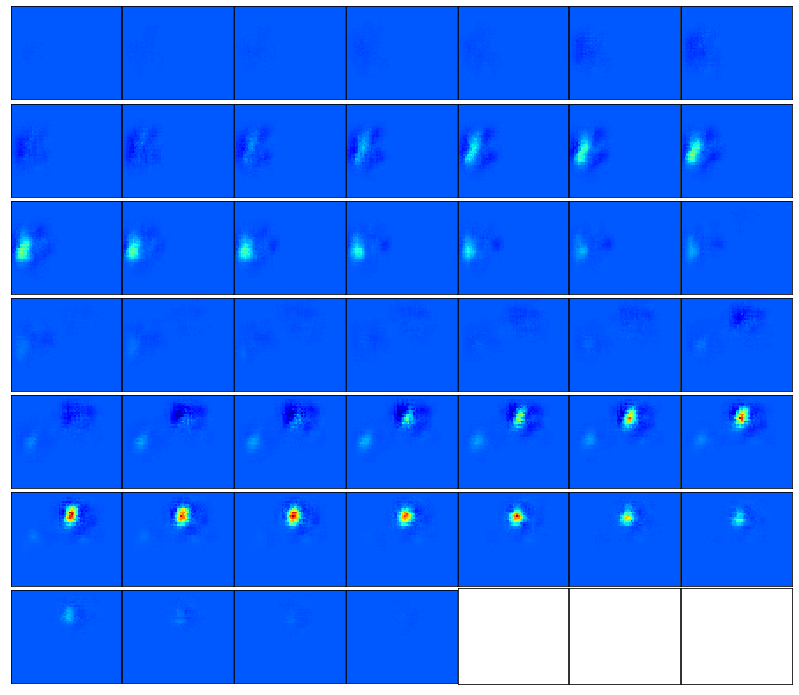

Task # : 2


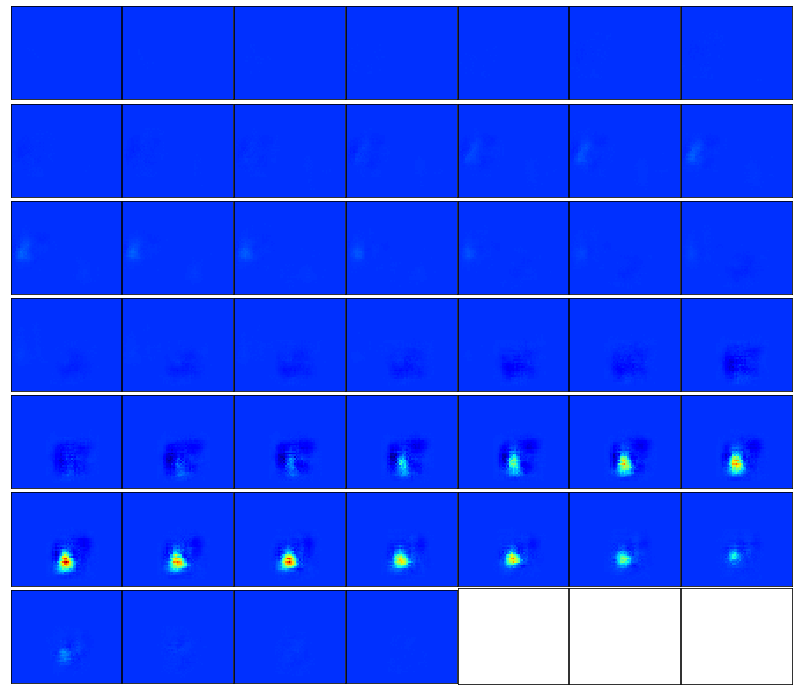

Task # : 3


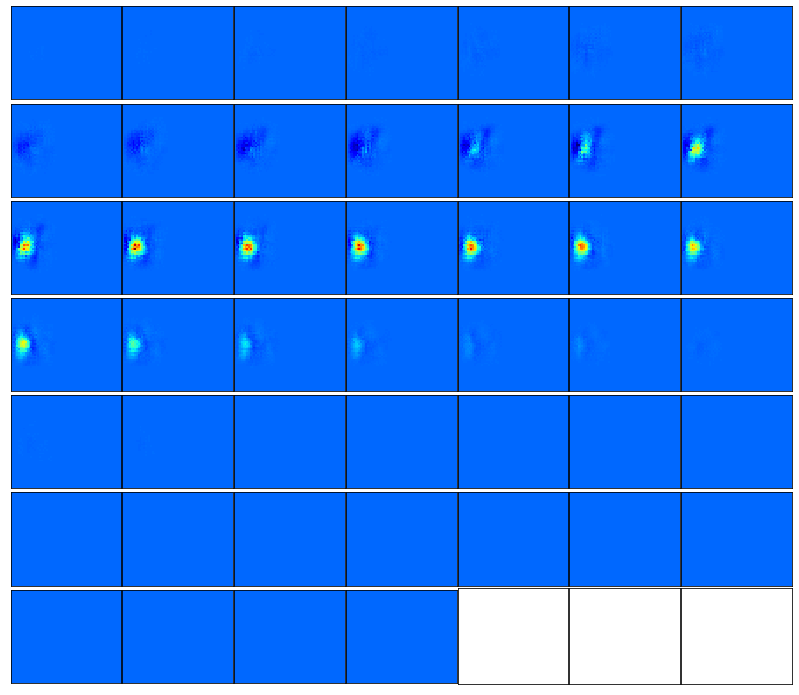

In [ ]:
# avg for each task
rslt_avg = np.zeros((4,53,63,46))
for ti in range(4):
    tp = np.mean(rslt[ti*30:(ti+1)*30,:],axis=0)
    rslt_avg[ti] = tp
    print('Task # :',ti)
    f,axes= plt.subplots(7,7, figsize=(14,12.5),subplot_kw={'xticks': [], 'yticks': []})
    f.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = axes.flat
    for i in range(46):
        ax[i].imshow(tp[:,:,i],vmin=tp.min(),vmax=tp.max(), cmap='jet')
    plt.show()